In [163]:
# Nama : Debora Udania Simanjuntak
# Email : debora.udania.simanjuntak@mail.ugm.ac.id
# Kelas : Belajar Pengembangan Machine Learning

In [135]:
# import the libraries and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [136]:
data_train=pd.read_csv("Corona_NLP_train.csv", delimiter=',',encoding='latin-1')
data_test=pd.read_csv("Corona_NLP_test.csv", delimiter=',',encoding='latin-1')

In [137]:
data=pd.concat([data_train,data_test],axis=0)

In [138]:
# Understanding the Data
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [139]:
# Delete the first 4 columns in data

data=data.drop(columns=["UserName","ScreenName","Location","TweetAt"])
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [140]:
data.Sentiment.unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [141]:
# The are 5 kind of sentiments in the data, they are Extremely Negative, Negative, Neutral, Extremey Positif and Positive
# Here I am going to group Extremely Negative and Negative into one group and Extremely Positive and Positive into one group as well
data["Sentiment"]=np.where(data["Sentiment"]=="Extremely Positive","Positive",data["Sentiment"])
data["Sentiment"]=np.where(data["Sentiment"]=="Extremely Negative","Negative",data["Sentiment"])

In [142]:
# Text Preprocessing to remove stopwords

import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [143]:
# Make a function to remove stopwords
from nltk.corpus import stopwords
import re

def remove_stopwords(input_text):
    stopwords_list=stopwords.words("english")
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

In [144]:
# Apply function to remove stopwords
data.OriginalTweet=data.OriginalTweet.apply(remove_stopwords)

In [145]:
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk neighbours family exchange phone n...,Positive
2,Coronavirus Australia: Woolworths give elderly...,Positive
3,"My food stock not one empty... PLEASE, panic, ...",Positive
4,"Me, ready go supermarket #COVID19 outbreak. No...",Negative


In [146]:
#  Change the string label into numeric form 
category=pd.get_dummies(data.Sentiment)
category
# Concat data and category
data=pd.concat([data,category],axis=1)
# Drop column Sentiment
data=data.drop(columns="Sentiment")
data.head()

,OriginalTweet,Negative,Neutral,Positive
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0,1,0
1,advice Talk neighbours family exchange phone n...,0,0,1
2,Coronavirus Australia: Woolworths give elderly...,0,0,1
3,"My food stock not one empty... PLEASE, panic, ...",0,0,1
4,"Me, ready go supermarket #COVID19 outbreak. No...",1,0,0


In [147]:
# Spilt data into train and test
from sklearn.model_selection import train_test_split as tts

X_data=data.OriginalTweet.values
y_data=data.iloc[:,1:6].values

X_train,X_test,y_train,y_test=tts(X_data,y_data,test_size=0.2,random_state=0)

In [148]:
y_train

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=uint8)

In [149]:
# Apply Tokenization so model will understand the data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [150]:
tokenizer=Tokenizer(num_words=5000,oov_token='-')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

sequence_train=tokenizer.texts_to_sequences(X_train)
sequence_test=tokenizer.texts_to_sequences(X_test)

padded_train=pad_sequences(sequence_train,maxlen=59)
padded_test=pad_sequences(sequence_test,maxlen=59)

In [151]:
# Build the model

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding,GlobalAveragePooling1D,Dense,LSTM,Dropout

In [152]:
model=Sequential([Embedding(input_dim=5000,output_dim=16),
                  LSTM(64, recurrent_dropout=0.4),
                  Dropout(0.3),
                  Dense(16, activation='relu'),
                  Dropout(0.3),
                  Dense(3,activation='softmax')])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [155]:
# Make callback function
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.85):
      print("\nAccuracy has reached>85%!")
      self.model.stop_training = True
callbacks = myCallback()

In [156]:
history=model.fit(padded_train,y_train, epochs=50,batch_size=32,
                  validation_data=(padded_test,y_test),verbose=2,callbacks=[callbacks])

Epoch 1/50
1124/1124 - 71s - loss: 0.4928 - accuracy: 0.8366 - val_loss: 0.4617 - val_accuracy: 0.8398
Epoch 2/50
1124/1124 - 71s - loss: 0.4186 - accuracy: 0.8705 - val_loss: 0.4564 - val_accuracy: 0.8465
Epoch 3/50
1124/1124 - 70s - loss: 0.3876 - accuracy: 0.8827 - val_loss: 0.4762 - val_accuracy: 0.8417
Epoch 4/50
1124/1124 - 70s - loss: 0.3647 - accuracy: 0.8886 - val_loss: 0.4482 - val_accuracy: 0.8474
Epoch 5/50
1124/1124 - 70s - loss: 0.3349 - accuracy: 0.8961 - val_loss: 0.4592 - val_accuracy: 0.8512

Accuracy has reached>85%!


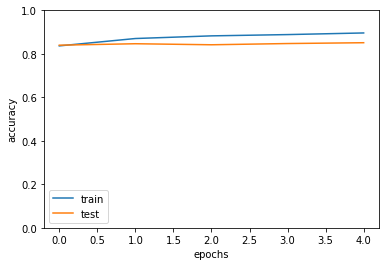

In [161]:
plt.plot(history.history.get('accuracy'))
plt.plot(history.history.get('val_accuracy'))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.ylim(0,1)
plt.show()

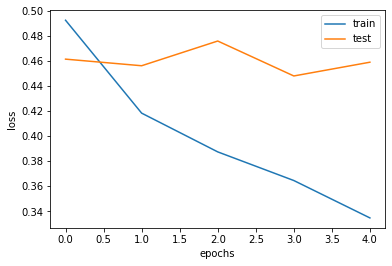

In [162]:
plt.plot(history.history.get('loss'))
plt.plot(history.history.get('val_loss'))
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()